In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Loading and Normalizing CIFAR-10
   The CIFAR-10 dataset contains 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

In [2]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4
# Download and load training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# Download and load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


## Why Normalize?
We normalize the images with mean=0.5 and standard deviation=0.5 for each channel (RGB) to help the model converge faster during training

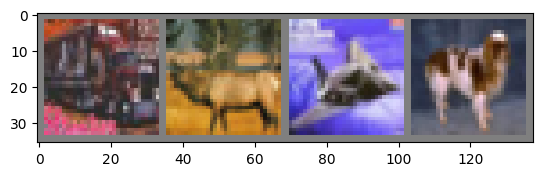

truckdeer planedog  


In [3]:
def imshow(img):
    img=img/2+0.5 #unormalize
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

# Get somerandom training images
dataiter=iter(trainloader)
images,labels=next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print lables
print(''.join(f'{classes[labels[j]]:5s}'for j in range (batch_size)))

##  Convolutional Neural Network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channels, 6 output channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        # 6 input channels, 16 output channels, 5x5 convolution
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
            # First conv block: conv -> relu -> pool
            x = self.pool(F.relu(self.conv1(x)))
            # Second conv block: conv -> relu -> pool
            x = self.pool(F.relu(self.conv2(x)))
            # Flatten for fully connected layers
            x = torch.flatten(x, 1)
            # Fully connected layers with ReLU activation
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            # Final output layer (no activation)
            x = self.fc3(x)
            return x
net = Net()

In [5]:
class BetterCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10, dropout_conv=0.25, dropout_fc=0.5):
        super().__init__()
        # Convolutional feature extractor (3 blocks)
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),   # 1/2 spatial
            nn.Dropout2d(dropout_conv),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),   # 1/4 spatial
            nn.Dropout2d(dropout_conv),

            # Block 3 (deeper)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),   # 1/8 spatial
            nn.Dropout2d(dropout_conv),
        )

        # make classification size-agnostic (works for different input sizes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # outputs [B, 256, 1, 1]
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_fc),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x
better_net = BetterCNN()

It adds more convolutional blocks, uses BatchNorm after each conv, and uses Dropout2d in the conv stack + Dropout in the classifier. It also uses AdaptiveAvgPool2d so you don't have to compute the flattened size manually.

1️⃣ in_channels
What it means

in_channels = number of channels in the input image

It must match your data.

| Image type               | Shape          | `in_channels` |
| ------------------------ | -------------- | ------------- |
| Grayscale (MNIST)        | `[B, 1, H, W]` | `1`           |
| RGB (CIFAR-10, ImageNet) | `[B, 3, H, W]` | `3`           |
| RGBA                     | `[B, 4, H, W]` | `4`           |

2️⃣ num_classes
What it means

num_classes = number of categories you want the model to predict

It controls the output size of the network.

## Where BatchNorm and Dropout are placed (and why)

BatchNorm2d: right after each Conv2d and before the activation. This stabilizes and speeds up training by normalizing channel activations.

Dropout2d (in conv blocks): randomly zeroes entire channels in feature maps — good for convolution layers.

Dropout (in classifier): regular dropout before the final linear layer to reduce overfitting.

AdaptiveAvgPool2d avoids manual calculation of flattened size (handy if you change input image size).

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.03, momentum=0.9)


In [7]:
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=72,
    shuffle=True
)
model = BetterCNN(in_channels=3, num_classes=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
model.train()  # put model in training mode

for epoch in range(10):  
    running_loss = 0.0
    print(f"Starting Epoch {epoch + 1}/20")

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 100 == 0:  # print every 100 batches
            print(f"Epoch {epoch + 1}, Batch {i + 1}/{len(trainloader)}, Loss: {running_loss / (i + 1):.4f}")

    avg_loss = running_loss / len(trainloader)
    print(f"Epoch [{epoch + 1}/20] Loss: {avg_loss:.4f}")

print("Finished Training")

Starting Epoch 1/20
Epoch 1, Batch 100/695, Loss: 2.0294
Epoch 1, Batch 200/695, Loss: 1.9703
Epoch 1, Batch 300/695, Loss: 1.9325
Epoch 1, Batch 400/695, Loss: 1.9035
Epoch 1, Batch 500/695, Loss: 1.8774
Epoch 1, Batch 600/695, Loss: 1.8541
Epoch [1/20] Loss: 1.8361
Starting Epoch 2/20
Epoch 2, Batch 100/695, Loss: 1.6605
Epoch 2, Batch 200/695, Loss: 1.6449
Epoch 2, Batch 300/695, Loss: 1.6249
Epoch 2, Batch 400/695, Loss: 1.6055
Epoch 2, Batch 500/695, Loss: 1.5844
Epoch 2, Batch 600/695, Loss: 1.5650
Epoch [2/20] Loss: 1.5458
Starting Epoch 3/20
Epoch 3, Batch 100/695, Loss: 1.4012
Epoch 3, Batch 200/695, Loss: 1.3702
Epoch 3, Batch 300/695, Loss: 1.3597
Epoch 3, Batch 400/695, Loss: 1.3486
Epoch 3, Batch 500/695, Loss: 1.3302
Epoch 3, Batch 600/695, Loss: 1.3178
Epoch [3/20] Loss: 1.3078
Starting Epoch 4/20
Epoch 4, Batch 100/695, Loss: 1.2027
Epoch 4, Batch 200/695, Loss: 1.2010
Epoch 4, Batch 300/695, Loss: 1.1941
Epoch 4, Batch 400/695, Loss: 1.1825
Epoch 4, Batch 500/695, Loss

## save our traing model

In [8]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

## Testing the Network
Now let’s see how our model performs on unseen test data:



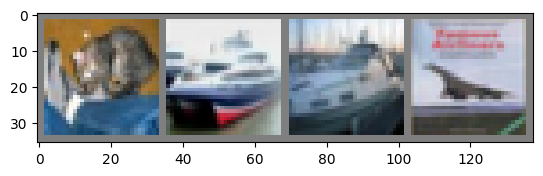

GroundTruth:  cat   ship  ship  plane


In [9]:
# Load some test images
dataiter = iter(testloader)
images, labels = next(dataiter)
# Display images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

##  let’s see what our model predicts

In [10]:
# Reload our model
model = BetterCNN(in_channels=3, num_classes=10).to(device)
model.load_state_dict(torch.load(PATH))
model.eval()

# Get predictions
images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', " ".join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  dog   car   ship  plane


## overall accuracy on the entire test set

In [11]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy of the network on the 10000 test images: {100 * correct // total} %")

Accuracy of the network on the 10000 test images: 81 %
